# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = data.loc[data.income=='>50K'].shape[0]

# Number of records where individual's income is at most $50,000
n_at_most_50k = data.loc[data.income=='<=50K'].shape[0]

# Percentage of individuals whose income is more than $50,000
greater_percent = float(n_greater_50k)*100/n_records

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

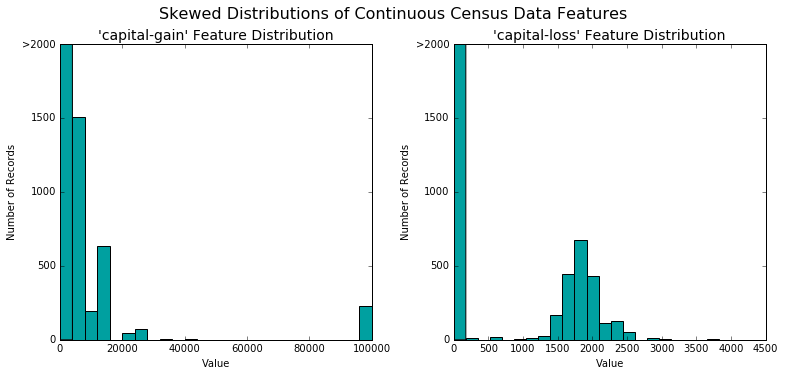

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

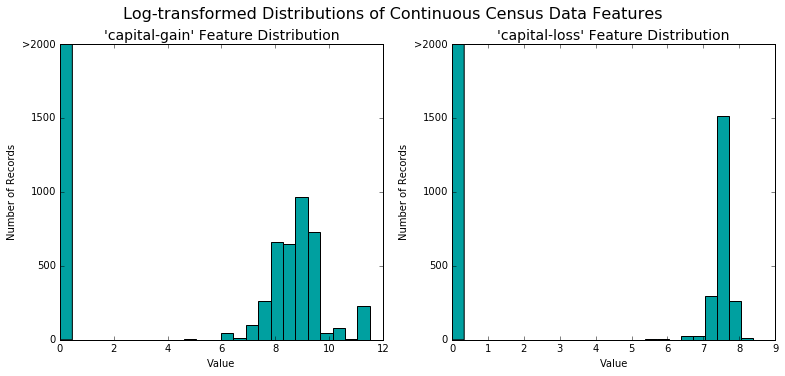

In [4]:
# Log-transform the skewed features

skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.00000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.00000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# Encode the 'income_raw' data to numerical values
income=income_raw.apply(lambda x:0 if x=='<=50K'  else 1)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
# print encoded

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*UdacityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *UdacityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would is appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *UdacityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *UdacityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [8]:
# Create naive prediction
naive_pred=pd.Series(np.ones(n_records), name='Naive_Prediction')

# Calculate accuracy
accuracy = np.float64((naive_pred==income).sum())/n_records

# Calculate F-score using the formula above for beta = 0.5
# the following calculation assume the postive label is 1 i.e. income>50000, in this binary classification scenario 
# the fscore equal to the fscore for the true positive class

# denote the following notion:
# tp1: true positive for positive label 
# fp1: false positive for positive label
# fn1: false negative for positive label 

tp1=income.loc[income==1].shape[0] #this equates to real total of people with income>50000
fp1=income.loc[income==0].shape[0] #this equates to real total of people with income<=50000
fn1=0                              #this is zero, since the naive prediction predict all people with income>50000  
beta=0.5

precision=float(tp1)/(tp1+fp1) 
recall=float(tp1)/(tp1+fn1)

fscore = (1+beta**2)*precision*recall/((beta**2*precision)+recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supverised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **

**choice of learning models**: The model I choose to for this discussions are *Logistic Regression*, *Stochastic Gradient Descent Classifier*, and *Gradient Boosting*. 

* *Logistic Regression*
    * *Industry Application:* An example of real-world application of logistic regression is for predictive modelling in the insurance industry. For instance, logistic regression has been applied to detect [auto insurance fault][1], in this case, it is used to help to narrow down the possible number of claims to be investigated for fraud by human inspector. 
    * *Strength:* 
        * [1][2] Convenient probability scores for observation 
        * [2][2] Efficient implementation across tools
        * [4][2] Wide spread industry usage
        * [4][4] Has low variance
        * [5][4] Works well with diagonal decision boundaries
    * *Weakness:* 
        * [1][2] Doesn't perform well when feature space is too large
        * [2][2] Doesn't handle large number of categorical features/variables well
        * [3][2] Relies on transformations for non-linear features
        * [4][2] Relie on entire dataset. 
        * [5][4] Has high bias
    
* *Stochastic Gradient Descent Classifier (SGDC)*
    * *Industry Application:* In this [community post][5] in Quantopian,  stochastic gradient descent is used to predict stock price. In this case, the random sampling nature of stochastic gradient descent increases  volatility of the prediction, but also increases the highest gain, compare an implementation using perceptron. In another example,  stochastic gradient descent is used to perform [event-based stock market prediction].[6]
    * *Strength:*
        * [1][3] Much faster than traditional gradient descent since it needs less computation each iteration
        * [2][3] It is known to be better with noisy data since it uses samples from dataset to compute gradient
        * [3][3] It has been successfully applied to large-scale and sparse machine learning problems and is easily scalable for large dataset
    * *Weakness:*
        * [1][3] The convergence rate is slower than second-order gradient methods. 
        * [2][3] It tends to keep bouncing around the minimum unless the learning rate is reduced in the later iterations 
   
* *Gradient Boosting*
    * *Industry Application:*  [XGBoost][11] - One variation of gradient boost - had become the the [dominant algorithm][12] in data science competition for learning from structured dataset. Gradient boosting has also been used for pharmaceutical research, for instance for choosing best [quantitative structure model][13]
    
    * *Strength:* 
        * [1][7] It is non-parametric when uses a decision tree as based learner. Therefore one doesn't need to worry about outliers or whether the data is linearly separable. 
        * [2][8] Gradient boosting models had been benchmarked and found to be generally outperforming popular ensembled model such as random forest - which in term identified as one of the best algorithms from an [extensive benchamrk exercise][10].  
    
    * *Weakness:*
        * [1][8]: Compare to other ensembled model such as random forest, gradient boosting required more effort of tuning due to larger number of hyperparameters.
        * [2][9]: It usually takes longer to train as it builds trees one at a time.

[1]:http://www.aabri.com/manuscripts/08103.pdf
[2]:http://www.edvancer.in/logistic-regression-vs-decision-trees-vs-svm-part2/
[3]:http://curtis.ml.cmu.edu/w/courses/index.php/Stochastic_Gradient_Descent
[4]:https://github.com/ctufts/Cheat_Sheets/wiki/Classification-Model-Pros-and-Cons
[5]:https://www.quantopian.com/posts/second-attempt-at-ml-stochastic-gradient-descent-method-using-hinge-loss-function
[6]:http://cs229.stanford.edu/proj2014/Hadi%20Pouransari,%20Hamid%20Chalabi,%20Event-based%20stock%20market%20prediction.pdf
[7]:http://http://www.cnblogs.com/yymn/p/4518016.html
[8]:http://fastml.com/what-is-better-gradient-boosted-trees-or-random-forest/
[9]:https://www.quora.com/What-are-the-advantages-disadvantages-of-using-Gradient-Boosting-over-Random-Forests
[10]:http://jmlr.org/papers/volume15/delgado14a/delgado14a.pdf
[11]:https://github.com/dmlc/xgboost
[12]:http://www.kdnuggets.com/2016/03/xgboost-implementing-winningest-kaggle-algorithm-spark-flink.html
[13]:http://pubs.acs.org/doi/abs/10.1021/acs.jcim.6b00591

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:
#Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, fbeta_score
import time
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set 
    '''
    results = {}
    # Fit the learner to the training data using sample_size
    start = time.time() # Get start time
    
    # Take the first n=sample_size data points for training
    X_train_sample=X_train.sample(sample_size)
    y_train_sample=y_train[X_train_sample.index]

    learner.fit(X_train_sample, y_train_sample)
    end = time.time() # Get end time

    # Calculate the training time
#     results['train_time'] = "{%0.5f} seconds" %(end-start)
    results['train_time'] = end-start
    
    # Get the predictions on the test set,
    # then get predictions on the first 300 training samples
    start = time.time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train_sample)
    end = time.time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train_sample.head(300), predictions_train[0:300])
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    # Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train_sample.head(300), predictions_train[0:300],beta=0.5)
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5) 
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
    
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Dependent on which algorithms you chose, the following implementation may take some time to run!

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
SGDClassifier trained on 361 samples.
SGDClassifier trained on 3617 samples.
SGDClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.


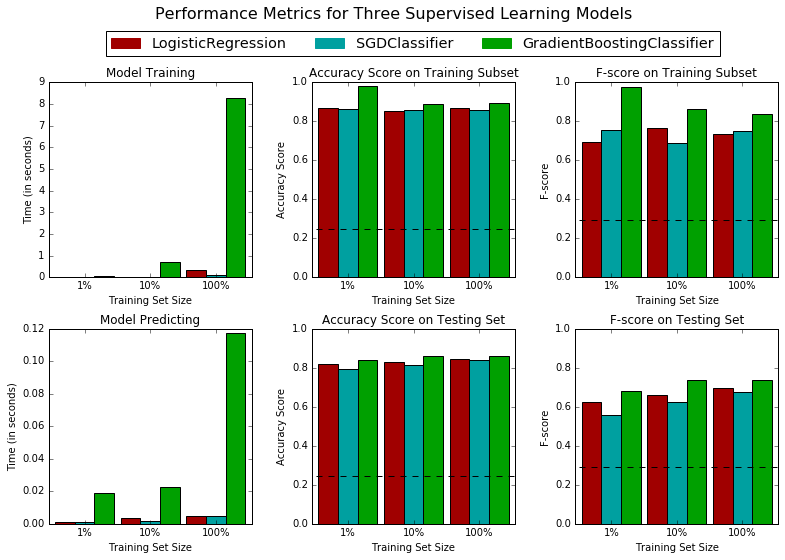

In [11]:
# Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

rand=111

# Initialize the three models
clf_A = LogisticRegression(random_state=rand)
clf_B = SGDClassifier(random_state=rand)
clf_C = GradientBoostingClassifier(random_state=rand)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = np.int(X_train.shape[0]*0.01)
samples_10 = np.int(X_train.shape[0]*0.1)
samples_100 = np.int(X_train.shape[0])

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: **

By performing this evaluation on different sampling size, we can see how each of the three models perform as the number of training data improve. In term of training time and prediction time, we can see among the three models, when comparing to the Logistic Regression and Stochastic Gradient Descent Classifier(SGDC), Gradient Boosting takes a far longer time to perform training and prediction. Importantly, we can observe that as the number of training data increase, the increase of training and prediction time for Gradient Boosting is much steeper than that of Logistic Regression and SGDC.  This last point is important, since if we are to have to increase the dataset size in the future, we will need to factor in the steep increase in training and prediction time when considering the suitability of Gradient Boosting.

In the other hand, in terms of modelling performance, Gradient Boosting provides the best classification performance among the three models. For both accuracy and F-score, Gradient Boosting provides the best score out of the three models in each scenario of three different sizes of samplings from training data. In particular, the F-score of Gradient Boosting is significantly better (with a margin of 0.04+ ) than those from Logistic Regression and SGDC. This indicates that in this classification task, Gradient Boosting is well suited to tackle an imbalance dataset such as this donor dataset. In this case, people earning more than 50000 is a minor class and the precision of correctly identify these people consider a priority. 

Based on the above discussion, I would suggest that Gradient Boosting as the best model for this classification task with the given dataset. It takes more time to train and predict, however, the performance is significantly better than the other two classifiers, especially considering the high priority of precision in classification. I consider that this gain in performance outstrips the longer training and prediction time. 





### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 

Gradient Boosting performs learning by constructing a base learner in a sequential manner in a specified number of boosting rounds. In this case, the base learner is decision tree. A decision tree tries to learn rules that can separate the data according to the label. For instance, in this case, a decision tree might separate data by a certain number of education years: since people beyong this given number of education year would be more likely to be on higher income, while people had less years of education would be more likely in low income. It might then further learn more rules in each division of data. For instance, it might find that within people in high income, certain age would provide a good threshold to further separate the data. So far and so forth. 

Therefore, in each boosting round, the Gradient Boosting model constructs one decision tree on the data. These decision trees are constructed in a way that the decision in a given boosting round learns from the error made by the decision tree in the previous round, and try to improve on it a little bit. This repeats until the number of boosting round is reached.  Since in each boosting round, the learner is learning the error of the previous round, the output of each round tends to perform finer and finer adjustment on previous error as the round increases.

While performing prediction, and in this case binary classification, Gradient Boosting performs classification of data points in each boosting round, and will use the classification at the final round as the final classification. 





### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [13]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the GradientBoostingClassifier
clf= GradientBoostingClassifier(random_state=111)

# Create the parameters list you wish to tune
parameters={'learning_rate':[0.2, 0.1, 0.05], # parameter for the learning rate of the GradientBoostingClassifer
            'n_estimators':[ 80, 100, 120,],  # the number of boosting round to perform 
            'max_depth':[3,4,5]}              #     

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method
# set cv=5 to perform 5-fold stratified cv for binary classification
# set n_jobs=-1 to run the maximum possible amount of parallel jobs
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer, cv=5, n_jobs=-1)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

print('best parameters is: ', grid_fit.best_params_)
print('------')

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

('best parameters is: ', {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 4})
------
Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8714
Final F-score on the testing data: 0.7538


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.2478         |   0.8630          |    0.8714       |
| F-score        |      0.2917         |   0.7395          |    0.7538       |


**Answer: **

After performing GridSearchCV with 5 foldCV in each grid search run, the estimator with the best score was used as the optimized model. When applied on the test dataset, this optimised model provides an accuracy score of 0.8714 and an F-score of 0.7538.   Both of these scores are improvements from the respective score from the unoptimized model (accuracy score: 0.8630, F-score: 0.7395). 

It is very likely that this optimised scored can be improved further if more parameters are included in the gridsearch. For Gradient Boosting, parameters such as *subsample* and *min_samples_split* can be used to provider further optimisation of the model.  However, as discussed above, the training time of Gradient Boosting is quite long - as shown in the comparison to Logistic Regression and SGD Classifier, and that further gridsearch with 5 fold CV for more parameters would take a considerable amount of time. IN an operational scenarios, one shall consider if the additional training time can be justified by having better model performan in return. 

This optimised model score is far better than that of the naive predictor benchmarks, which is not surprising since the model is learning effectively from the features of the dataset. 


----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them?_

**Answer:**

of the thirteen features in the dataset, I would suggest that the following features are particularly relevant for to the label. The relevance order of these features is provided in the list according to their ranking: _capital-gain_ being the most relevant, _age_ being the 5th in relevancy to income status. 

- **_capital-gain_**: the more monetary gain one person has, the higher likelihood this person is of high income
- **_occupation_:** certain types of occupation can be directly link with income status. For instance, someone in an 'executive management' occupation is very likely to have a high income, while someone in an 'admin-clerical' occupation is more likely to have lower income.
- **_education-num_**: the longer someone spends in education, the higher chance they have advanced degrees and therefore employed in a high-income professional job. This feature is likely to be close related to that of educational_level, however, this also accounts for the potential that someone pursues continuously study for a long time after graduation. 
- **_relationship_**: First of all,  there is still a larger percentage of a male in high-income job due to traditional population trend in which more husband was being the 'bread winner' fo the family while the wife stayed at home. Additionally, a person in certain types of relationship i.e. husband or wife tends to indicate that person is beyond certain age range which is itself correlated with income.  
- **_age_**: People with older age is more likely to have a long time in education, and also have more time to develop in their career path, and therefor likely have a higher income. 

The following figures provide data analysis to indicate the relevancy of identified feature with respect to income status. High relevancy is indicated by a significant difference in the distribution of a given feature w.r.t. to the income status over the population.


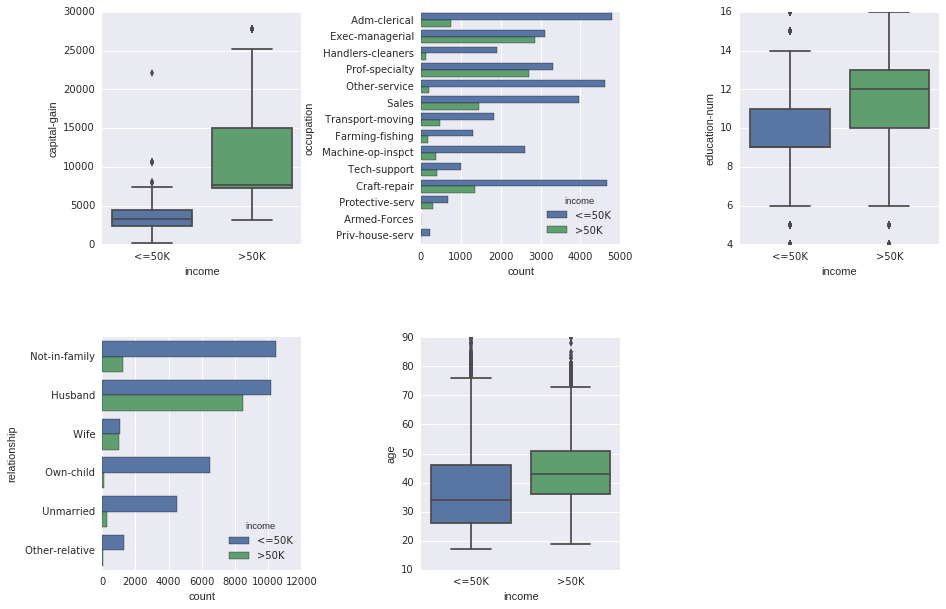

In [52]:
# Exploratory Data Analysis to demonstrate features that are identified as particular relevant
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
plt.subplots_adjust(wspace=0.6, hspace=0.4)

# capital-gain
up_val, low_val=30000, 0
data_select=data.loc[(data['capital-gain']<=up_val) & (data['capital-gain']>low_val) ]
sns.boxplot(x='income', y='capital-gain', data=data_select,ax=axes[0][0])


# Occupation 
sns.countplot(y='occupation', hue='income', data=data, ax=axes[0][1])

# education_num
up_val, low_val=20, 3
data_select=data.loc[(data['education-num']<=up_val) & (data['education-num']>low_val) ]
sns.boxplot(x='income', y='education-num', data=data_select,ax=axes[0][2])



# relationship
sns.countplot(y='relationship', hue='income', data=data, ax=axes[1][0])

# age
sns.boxplot(x='income', y='age', data=data,ax=axes[1][1])

fig.delaxes(axes[1][2])

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

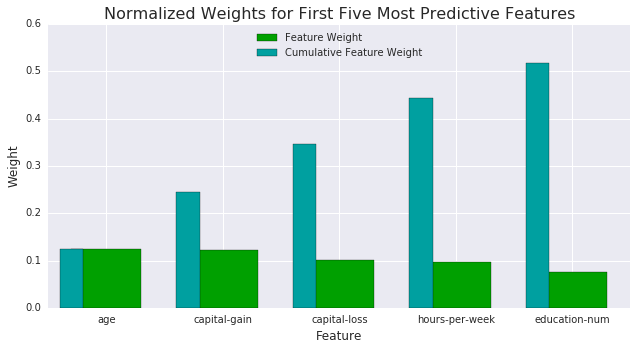

In [55]:
# Import a supervised learning model that has 'feature_importances_' --- use Gradient Boosting here

# use the optimised setting identified via GridSearchCV  
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.2, max_depth=4, random_state=111)
model.fit(X_train, y_train)

# Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)


### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**

Based on the above feature importance figure, the features '_age_', '_capital-gain_', '_capital-loss_', '_hours-per-week_', '_education-num_' were determinted by the model to be the most important. 

Three of the above features were identified in the discussion for **_Question 6_**, in the order of: '_capital-gain_', '_education-num_' and '_age_'. therefore, on top of disagreement on two features, the feature importance ranking provided by the model is different to what I had anticipated. 

Despite the difference, I consider the observation made in **_Question 6_** to be still valid. I did also perform the correlation analysis between income status and the two disagreed features '_capital-loss_' and '_hour-per-week_', I however didn't feel the distribution difference between two income status groups in this two features to be as significant that those for '_occupation_' and '_relation_'. 

Additionally, the features that were identified in the discussion for **_Question 6_** were the original feature before one-hot encoding. After one-hot encoding, the two features '_occupation_' and '_relation_' are no longer present in its original form. Instead, these features are now presented as dummy features with either 0 or 1 values. 

In the figure present in the following cell, the importance of the top 15 features are displayed. As shown in this figure, many of the dummy features related to the original '_relationship_' (such as '*relationship_Wife*') and '_occupation_' (such as '*occupation_Exec-managerial*') features are considered to be important.   


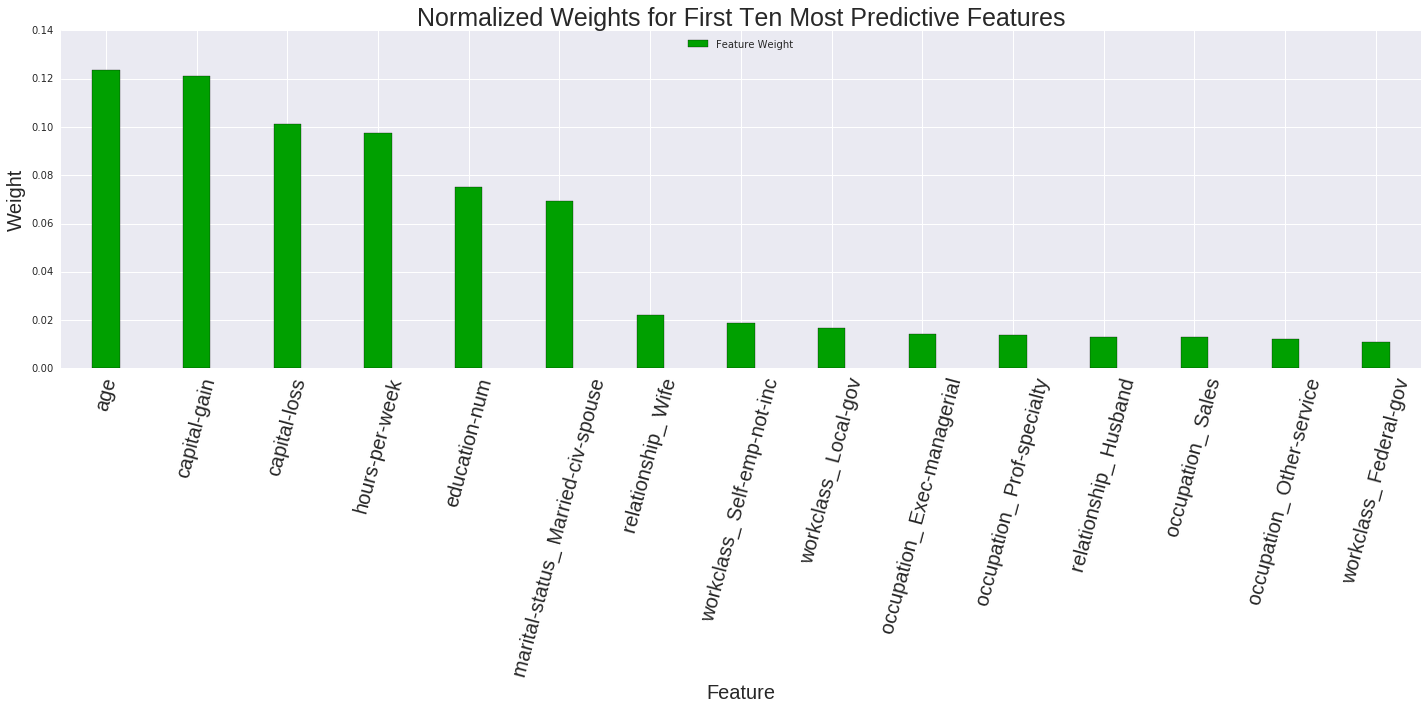

In [73]:
# modify the feature_plot function in the original vs utility to display specified number of features importance
def feature_plot_n(importances, X_train, y_train, feature_num):
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:feature_num]]
    values = importances[indices][:feature_num]    
    # Creat the plot
    fig = plt.figure(figsize = (20,10))
    plt.title("Normalized Weights for First Ten Most Predictive Features", fontsize = 25)
    plt.bar(np.arange(feature_num), values, width = 0.3, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.xticks(np.arange(feature_num), columns, rotation=75, fontsize = 20)
    plt.xlim((-0.5, feature_num-0.5))
    plt.ylabel("Weight", fontsize = 20)
    plt.xlabel("Feature", fontsize = 20)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  
    
feature_plot_n(importances, X_train, y_train, 15)

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [88]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
# clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# replace the original code with the following line.
# re-building the best model with the ame parameters identified by GridSearchCV
# this allow for direct creating of the best model - saving the time for performing GridSearchCV after a reload. 

# re-fit the optimised model to measure training time and prediction time. 
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.2, max_depth=4, random_state=111)

best_fit_start=time.time()
model.fit(X_train, y_train)
best_fit_time=time.time()-best_fit_start


# recreating the best_prediction, and measure prediction time. 
best_predict_start=time.time()
best_predictions = model.predict(X_test)
best_predict_time=time.time()-best_predict_start


# Report scores from the best model, training time and prediction time
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "Training time is : {:.4f} seconds".format(best_fit_time)
print "Prediction time is :{:.4f} seconds".format(best_predict_time)



reduced_fit_start=time.time()
clf=clone(model).fit(X_train_reduced, y_train)
reduced_fit_time=time.time()-reduced_fit_start

# Make new predictions
reduced_prediction_start=time.time()
reduced_predictions = clf.predict(X_test_reduced)
reduced_predict_time=time.time()-reduced_prediction_start

# Report scores from the reduced model, training time and prediction time
print "\nFinal Model trained on reduced data (top 5 features)\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))
print "Training time is : {:.4f} seconds".format(reduced_fit_time)
print "Prediction time is :{:.4f} seconds".format(reduced_predict_time)


# additionally report scores from using the top 15 features.
X_train_top15 = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:15]]]
X_test_top15 = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:15]]]

top15_fit_start=time.time()
clf_top15=clone(model).fit(X_train_top15, y_train)
top15_fit_time=time.time()-top15_fit_start

# Make new predictions for top 15 features
top15_prediction_start=time.time()
top15_predictions = clf_top15.predict(X_test_top15)
top15_prediction_time=time.time()-top15_prediction_start

print "\nFinal Model trained on data with top 15 features\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, top15_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, top15_predictions, beta = 0.5))
print "Training time is : {:.4f} seconds".format(top15_fit_time)
print "Prediction time is :{:.4f} seconds".format(top15_prediction_time)

Final Model trained on full data
------
Accuracy on testing data: 0.8714
F-score on testing data: 0.7538
Training time is : 12.1160 seconds
Prediction time is :0.0179 seconds

Final Model trained on reduced data (top 5 features)
------
Accuracy on testing data: 0.8429
F-score on testing data: 0.6996
Training time is : 1.1965 seconds
Prediction time is :0.0112 seconds

Final Model trained on data with top 15 features
------
Accuracy on testing data: 0.8666
F-score on testing data: 0.7431
Training time is : 2.5358 seconds
Prediction time is :0.0126 seconds


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**

With the reduced dataset with top 5 features, the model's F-score and accuracy are both lower than those obtained from training on the full dataset. However, both scores remained on the same level. with accuracy score worsens by 0.03, and F-scroe worsen by 0.06. In the other hand, with the reduced dataset, the training time had been shortened greatly - it took less than 10% of the time required for the full dataset. 

Depend on the business need, one can argue that the performance is still on the same level and the gain on the training time is very significant so that using the reduced dataset can be justified. However, there is also the argument that a 0.06 drop in F-Score is not ideal for a business problem where precision is prioritised. 

As also shown in the above implementation, one has the choice to implement the model using the dataset with top 15 features. In this case, both the accuracy and F-score are only slightly worsened very slightly, 0.005 and 0.01 respectivel, from the best model scores. This way one can still achieve a big gain from training time - 9.6 seconds faster than training on all the features.




> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.